# Regional price index formation
This is used to calculate regional price index for non-tradeable goods. This is needed to calculate regional real wages

General strategy: Get quaertly inflation numbers, use base price levels for the differention regions, calculate prices levels overtime using the quaertly inflation numbers

#### Not sure what this is doing

In [1]:
import sys
from pathlib import Path

p = Path.cwd().resolve()
repo_root = next((parent for parent in [p] + list(p.parents) if (parent / ".git").exists()), None)
if repo_root is None:
    raise RuntimeError("Repo root not found. Open the repo folder in VS Code.")

sys.path.insert(0, str(repo_root))
print("Repo root:", repo_root)

Repo root: C:\Users\maxah\OneDrive\2. Imperial\3. 3rd Year\4. Final project\1. FP_code\Group_Project_Y3


#### Load in data and files

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
#import price data
regional_prices_path = repo_root / "raw" / "00_regional_price" / "region_price.csv"
inflation = pd.read_csv(regional_prices_path,sep=';')

#### Convert into a clean data frame in long format

#### Functions

In [55]:
#function for cleaner the column headers
def clean_header(col_name):
    if "quarter" not in col_name.lower():
        return col_name # Keep index columns as they are
    
    # Split by semicolon: ["quarter 1", "total - ...", "2024", "[-]"]
    parts = col_name.split(';')
    
    # Extract pieces
    quarter = parts[0].strip().replace('quarter ', 'Q') # "quarter 1" -> "Q1"
    category = parts[1].split(' - ')[0].strip()        # "total - previous..." -> "total"
    year = parts[2].strip()                            # "2024"
    
    # Return a combined string we can split later
    return f"{category}|{quarter}_{year}"


#function to convert quarter-year string to datetime
def to_date(qy_str):
    q, year = qy_str.split('_')
    # Map Quarters to the first month of that quarter
    month_map = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
    return pd.to_datetime(f"{year}-{month_map[q]}-01")


#### Implementation
This leaves us with a clean long dataframe

In [69]:
# Rename the columns
inflation.columns = [clean_header(c) for c in inflation.columns]

#melt the dataframe into long format
id_cols = [c for c in inflation.columns if '|' not in c] # columns like 'Country' or 'ID'
inflation_long = inflation.melt(id_vars=id_cols, var_name='Metadata', value_name='Value')
#split the heading names into separate columns
inflation_long[['category', 'quarter_year']] = inflation_long['Metadata'].str.split('|', expand=True)

#convert quarter-year string to datetime
inflation_long['Date'] = inflation_long['quarter_year'].apply(to_date)

#final Clean up
inflation_final = inflation_long.drop(columns=['Metadata'])

In [70]:
inflation_final['Name'].unique()

array(['POLAND', 'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE',
       'LUBUSKIE', 'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE',
       'PODKARPACKIE', 'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE',
       'ŚWIĘTOKRZYSKIE', 'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE',
       'ZACHODNIOPOMORSKIE'], dtype=object)

<Axes: xlabel='Date', ylabel='Value'>

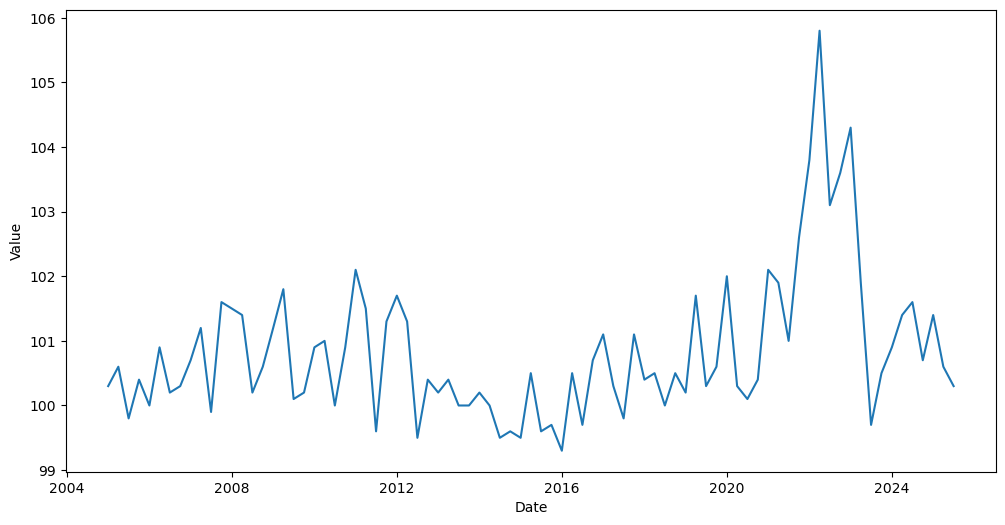

In [71]:
poland = inflation_final[  (inflation_final['category'] == 'total') & (inflation_final['Name'] == 'POLAND')]
poland_inflation = poland.sort_values('Date')
plt.figure(figsize=(12,6))
sns.lineplot(data=poland_inflation, x='Date', y='Value')

# Price levels

In [78]:
#load in GDP data
regional_GDP_current_path = repo_root / "raw" / "00_regional_GDP" / "GDP_current_prices.csv"
regional_GDP_PPS_path = repo_root / "raw" / "00_regional_GDP" / "GDP_PPS.csv"

GDP_current = pd.read_csv(regional_GDP_current_path,sep=';')
GDP_PPS = pd.read_csv(regional_GDP_PPS_path)
GDP_PPS = GDP_PPS[['Unit of measure','TIME_PERIOD','OBS_VALUE','Geopolitical entity (reporting)']]

In [79]:
GDP_PPS.head()

,Unit of measure,TIME_PERIOD,OBS_VALUE,Geopolitical entity (reporting)
0,"Purchasing power standard (PPS, EU27 from 2020...",2014,18300,Poland
1,"Purchasing power standard (PPS, EU27 from 2020...",2015,19400,Poland
2,"Purchasing power standard (PPS, EU27 from 2020...",2016,19700,Poland
3,"Purchasing power standard (PPS, EU27 from 2020...",2017,20700,Poland
4,"Purchasing power standard (PPS, EU27 from 2020...",2018,21900,Poland
